### Baseline U-net model following Torres and Sacchi 2021

In this notebook we build our benchmark CNN (U-net), train it, generate some figures and save the model to disk

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import scipy.misc
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Concatenate
#from tensorflow.keras.layers.merging.base_merge import _Merge
from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [3]:
def LSMNet_Block(X, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=True, initializer="HeNormal"):
    """
    Implementation of the Path 1 in the LSMNet
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of this block
    kernel_size -- python list of integers, defining the size of the filters in the CONV layers of this block
    strides -- python list of integers, defining the strides of the filters in the CONV layers of this block
    BatchNorm -- python list of integers, defining whether or not batch normalization will take place in each layer of this block
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to HeNormal
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
  
    
    # Retrieve Filters
    F1,   F2, FM,   FT = filters
    BN1, BN2,      BNT = BatchNorm
    KS1, KS2,      KST = kernel_size
    ST1, ST2, STM, STT = strides

    # Max Pooling
    if(ApplyMaxPooling):
        X = MaxPooling2D((FM, FM), strides=(STM, STM))(X)
    
    # First Convolution
    X = Conv2D(filters = F1, kernel_size = KS1, strides = (ST1,ST1), padding = 'same', kernel_initializer = initializer)(X)
    if BN1==1:
        X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Second Convolution
    X = Conv2D(filters = F2, kernel_size = KS2, strides = (ST2,ST2), padding = 'same', kernel_initializer = initializer)(X)
    if BN2==1:
        X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Transpose Convolution
    if(ApplyConvTransp):
        X = Conv2DTranspose(filters = FT, kernel_size = KST, strides = (STT,STT), padding='same', kernel_initializer = initializer)(X)
        if BNT==1:
            X = BatchNormalization(axis = 3)(X, training = training) # Default axis
        # X = Activation('relu')(X)

    return X

In [4]:
def LSMNet_unit(X_input, training=True, initializer="HeNormal"):
    """
    Stage-wise implementation of the architecture of the U-Net for LSM RTM:
    
    Arguments:
    X_input -- tensor input to this unit
    training -- defines whether it is training or not
    initializer -- defines the initializer

    Returns:
    X_output -- tensor output by this unit
    """

    # Block 1 (2 layers, 32 filters)
    ApplyMaxPooling = 0
    ApplyConvTransp = 0
    filters     = [32, 32, 0, 0]
    kernel_size = [ 3,  3,    0]
    strides     = [ 1,  1, 0, 0]
    BatchNorm   = [ 0,  0,    0]
    X_block1 = LSMNet_Block(X_input, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=training, initializer="he_normal")

    # Block 3 (3 layers, 64 filters)
    ApplyMaxPooling = 1
    ApplyConvTransp = 0
    filters     = [64, 64, 1, 0]
    kernel_size = [ 3,  3,    0]
    strides     = [ 1,  1, 2, 0]
    BatchNorm   = [ 0,  0,    0]
    X_block3 = LSMNet_Block(X_block1, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=training, initializer="he_normal")

    # Block 5 (3 layers, 128 filters)
    ApplyMaxPooling = 1
    ApplyConvTransp = 1
    filters     = [128, 128, 1, 64]
    kernel_size = [  3,   3,     3]
    strides     = [  1,   1, 2,  2]
    BatchNorm   = [  0,   0,     0]
    X_block5 = LSMNet_Block(X_block3, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=training, initializer="he_normal")

    # Concatenation 3-5
    X_cat35 = Concatenate(axis=3)([X_block3, X_block5])
    
    # Block 4 (2 layers, 64 filters)
    ApplyMaxPooling = 0
    ApplyConvTransp = 1
    filters     = [64, 64, 0, 32]
    kernel_size = [ 3,  3,     3]
    strides     = [ 1,  1, 0,  2]
    BatchNorm   = [ 0,  0,     0]
    X_block4 = LSMNet_Block(X_cat35, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=training, initializer="he_normal")

    # Concatenation 1-4
    X_cat14 = Concatenate(axis=3)([X_block1, X_block4])
    
    # Block 2 (3 layers, 32 filters)
    ApplyMaxPooling = 0
    ApplyConvTransp = 0
    filters     = [32, 32, 0,  0]
    kernel_size = [ 3,  3,     0]
    strides     = [ 1,  1, 0,  0]
    BatchNorm   = [ 0,  0,     0]
    X_block2 = LSMNet_Block(X_cat14, filters, kernel_size, strides, BatchNorm, ApplyMaxPooling, ApplyConvTransp, training=training, initializer="he_normal")


    # Final Convolution
    X_end = Conv2D(filters = 1, kernel_size = 3, strides = (1,1), padding = 'same', kernel_initializer = "he_normal")(X_block2)
#     X_end = Activation('relu')(X_end)


    # Output layer
    # X_sumInpBlock2 = Add()([X_input,X_block2])
    X_add        = Add()([X_input,X_end])
    X_output     = X_add
    
#     X_normAxis3  = BatchNormalization(axis = 3)(X_add      , training = training) # Default axis
#     X_output     = BatchNormalization(axis = 2)(X_normAxis3, training = training) # Default axis
#     X_output = Activation('tanh')(X_add)

    return X_output

In [5]:
def LSMNet_model(input_shape = (400, 200, 1), training=True, initializer="he_normal"):
    """
    Arguments:
    input_shape -- shape of the images of the dataset
    training -- defines whether it is training or not
    initializer -- defines the initializer

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X_output = LSMNet_unit(X_input, training=True, initializer=initializer)
    
    # Create model
    model = Model(inputs = X_input, outputs = X_output)

    return model

In [6]:
# Build the baseline U-net model
LSMNet = LSMNet_model(input_shape = (256, 128, 1), training=True, initializer="HeNormal")
print(LSMNet.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 128, 32) 9248        activation[0][0]                 
______________________________________________________________________________________________

In [7]:
# Build the optimizer and compile
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
LSMNet.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.CosineSimilarity()])

In [12]:
# Load the training and validation data
ntraining_file = 14
nexamples=512
nw=256
nh=128
nc=1
training_data=np.zeros((ntraining_file*nexamples,nw,nh))
training_labels=np.zeros((ntraining_file*nexamples,nw,nh))

validation_data=np.zeros((nexamples,nw,nh))
validation_labels=np.zeros((nexamples,nw,nh))

prefix0="/sep/nmbader/data/cs230/"
prefix1="mig1_batch"
prefix2="mig2_batch"
suffix="_augmented.npy"
for i in range(0,ntraining_file):
  filename=prefix0+prefix2+str(i*64)+suffix
  print(filename)
  training_data[i*nexamples:(i+1)*nexamples] = np.load(filename)
  filename=prefix0+prefix1+str(i*64)+suffix
  print(filename)
  training_labels[i*nexamples:(i+1)*nexamples] = np.load(filename)

print("Validation data")
filename=prefix0+prefix2+str(ntraining_file*64)+suffix
print(filename)
validation_data[:] = np.load(filename)
filename=prefix0+prefix1+str(ntraining_file*64)+suffix
validation_labels[:] = np.load(filename)
print(filename)

/sep/nmbader/data/cs230/mig2_batch0_augmented.npy
/sep/nmbader/data/cs230/mig1_batch0_augmented.npy
/sep/nmbader/data/cs230/mig2_batch64_augmented.npy
/sep/nmbader/data/cs230/mig1_batch64_augmented.npy
/sep/nmbader/data/cs230/mig2_batch128_augmented.npy
/sep/nmbader/data/cs230/mig1_batch128_augmented.npy
/sep/nmbader/data/cs230/mig2_batch192_augmented.npy
/sep/nmbader/data/cs230/mig1_batch192_augmented.npy
/sep/nmbader/data/cs230/mig2_batch256_augmented.npy
/sep/nmbader/data/cs230/mig1_batch256_augmented.npy
/sep/nmbader/data/cs230/mig2_batch320_augmented.npy
/sep/nmbader/data/cs230/mig1_batch320_augmented.npy
/sep/nmbader/data/cs230/mig2_batch384_augmented.npy
/sep/nmbader/data/cs230/mig1_batch384_augmented.npy
/sep/nmbader/data/cs230/mig2_batch448_augmented.npy
/sep/nmbader/data/cs230/mig1_batch448_augmented.npy
/sep/nmbader/data/cs230/mig2_batch512_augmented.npy
/sep/nmbader/data/cs230/mig1_batch512_augmented.npy
/sep/nmbader/data/cs230/mig2_batch576_augmented.npy
/sep/nmbader/data/

In [13]:
# convert to tensorflow and reshape
training_data = tf.convert_to_tensor(training_data)
training_labels = tf.convert_to_tensor(training_labels)

validation_data = tf.convert_to_tensor(validation_data)
validation_labels = tf.convert_to_tensor(validation_labels)

training_data=tf.reshape(training_data, [nexamples*ntraining_file, nw, nh, nc])
training_labels=tf.reshape(training_labels, [nexamples*ntraining_file, nw, nh, nc])

validation_data=tf.reshape(validation_data, [nexamples, nw, nh, nc])
validation_labels=tf.reshape(validation_labels, [nexamples, nw, nh, nc])

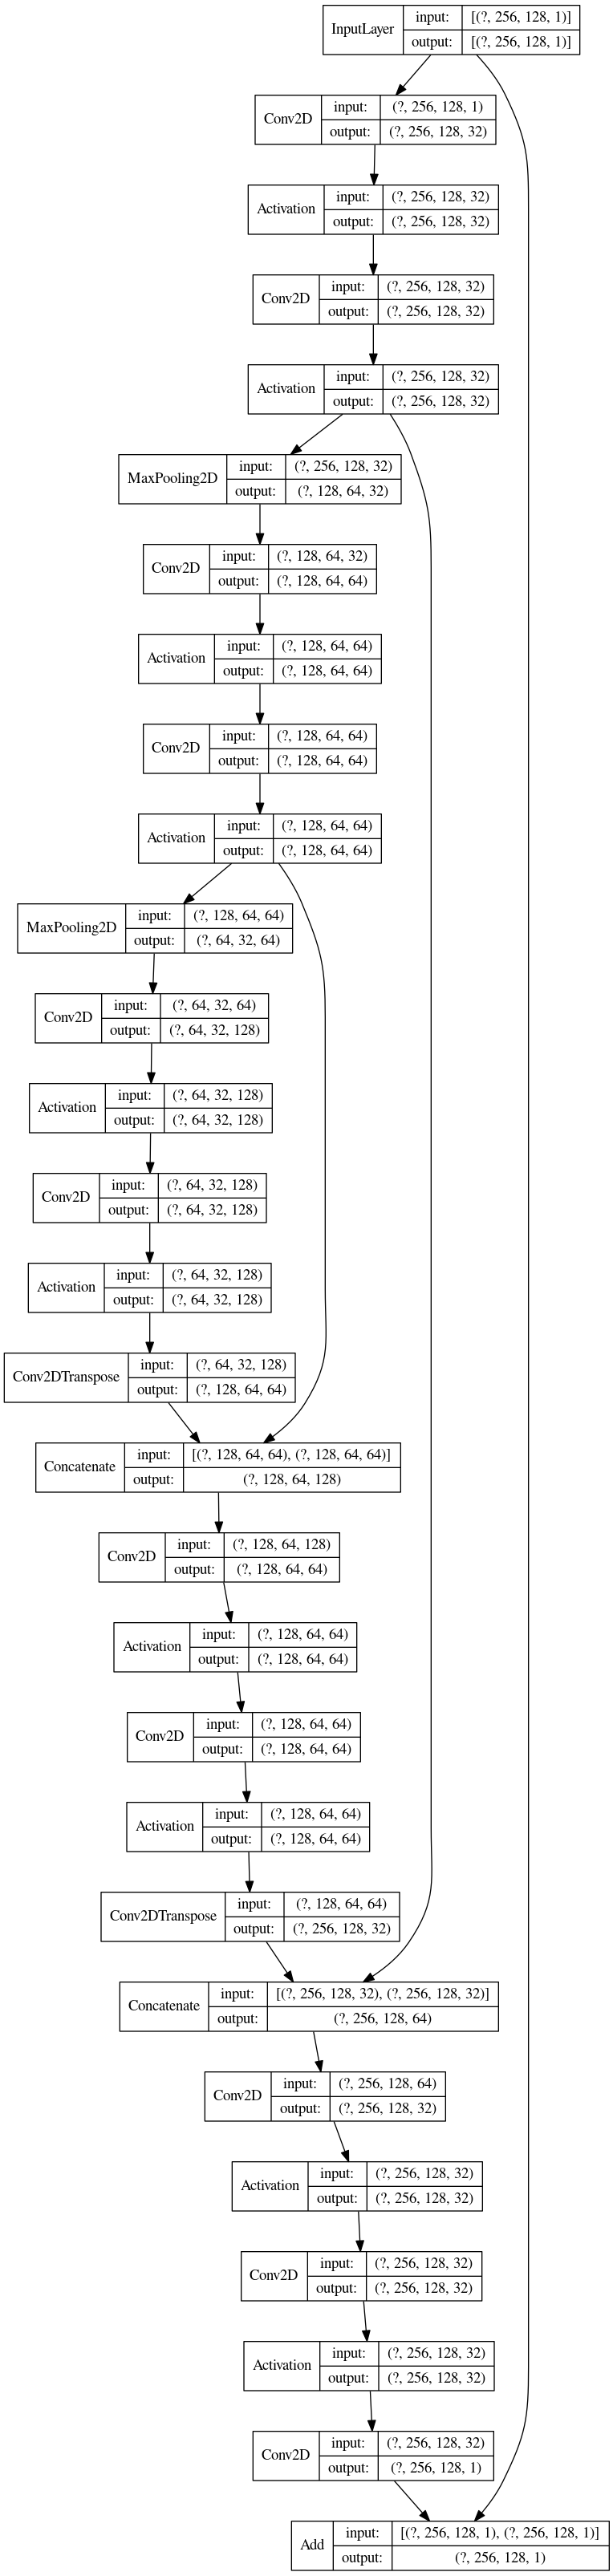

In [14]:
# visualize the model
tf.keras.utils.plot_model(
    LSMNet,
    to_file="fig/LSMNet_v0.png",
    show_shapes=True,
#     show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
)

In [ ]:
# run the training
EPOCHS = 21
BATCH_SIZE = 2
model_history = LSMNet.fit(
    x=training_data, 
    y=training_labels, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(validation_data, validation_labels)
)

Epoch 1/21
3584/3584 [==============================] - 349s 97ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - cosine_similarity: 0.7107 - val_loss: 6.4673e-04 - val_root_mean_squared_error: 0.0254 - val_cosine_similarity: 0.7530
Epoch 2/21
3584/3584 [==============================] - 351s 98ms/step - loss: 5.8384e-04 - root_mean_squared_error: 0.0242 - cosine_similarity: 0.7451 - val_loss: 4.2289e-04 - val_root_mean_squared_error: 0.0206 - val_cosine_similarity: 0.7511
Epoch 3/21
3584/3584 [==============================] - 350s 98ms/step - loss: 4.1140e-04 - root_mean_squared_error: 0.0203 - cosine_similarity: 0.7601 - val_loss: 2.9818e-04 - val_root_mean_squared_error: 0.0173 - val_cosine_similarity: 0.7764
Epoch 4/21
3584/3584 [==============================] - 351s 98ms/step - loss: 3.2599e-04 - root_mean_squared_error: 0.0181 - cosine_similarity: 0.7714 - val_loss: 2.1788e-04 - val_root_mean_squared_error: 0.0148 - val_cosine_similarity: 0.7852
Epoch 5/21
3584/3584 [==

In [17]:
# save the model and history
LSMNet.save(prefix0+'LSMNet_v0')
np.save(prefix0+'LSMNet_v0_history.npy',model_history.history)

INFO:tensorflow:Assets written to: /sep/nmbader/data/cs230/LSMNet_v0/assets


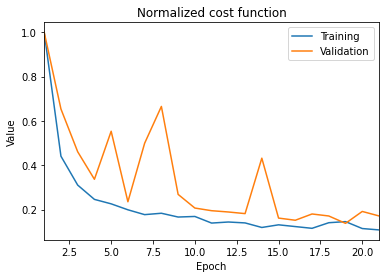

In [51]:
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["loss"]/np.max(model_history.history["loss"]),label="Training")
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["val_loss"]/np.max(model_history.history["val_loss"]),label="Validation")
plt.xlim([1,EPOCHS])
# plt.ylim([0, 1.1])
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Normalized cost function")
plt.savefig("fig/LSMNet_v0_cost_func.png")

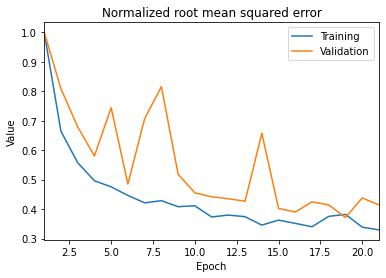

In [52]:
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["root_mean_squared_error"]/np.max(model_history.history["root_mean_squared_error"]),label="Training")
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["val_root_mean_squared_error"]/np.max(model_history.history["val_root_mean_squared_error"]),label="Validation")
plt.xlim([1,EPOCHS])
# plt.ylim([0, 1.1])
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Normalized root mean squared error")
plt.savefig("fig/LSMNet_v0_rms_error.png")

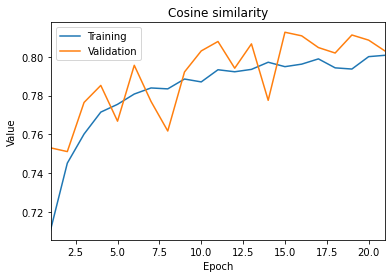

In [53]:
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["cosine_similarity"],label="Training")
plt.plot(np.linspace(1,EPOCHS,EPOCHS),model_history.history["val_cosine_similarity"],label="Validation")
plt.xlim([1,EPOCHS])
#plt.ylim([0, 1.1])
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Cosine similarity")
plt.savefig("fig/LSMNet_v0_cosine_similarity.png")

In [49]:
# reload the model and history for checking
model = tf.keras.models.load_model(prefix0+'LSMNet_v0')
model_history_npy = np.load(prefix0+'LSMNet_v0_history.npy',allow_pickle='TRUE').item()